# Volatilidad Implicita - Grupo 3

Problema: Construccion de una grilla arbitraria $(K,T)$ tal que para cada valor se obtenga la volatilidad implicita del modelo de Black-Scholes $\sigma_{BS} = \sigma (K,T)$, calibrada de tal manera que refleje adecuadamente el precio de mercado de un derivado para los valores de la grilla

## Heston

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, fsolve
from scipy.integrate import simps
import time

In [2]:
# Modulos especificos del cuaderno
from arbitrage import *   #Importa checkeos de arbitraje
from pricers import *     #Importa funciones para computar los precios de Heston y HestonWJ
from impvol import *      #Importa funciones para conseguir la volatilidad implicita
from opcion_europea_bs import opcion_europea_bs  #importa la formula de BSM

### Simulacion

El proceso de Heston se puede ver simulado en lo siguente

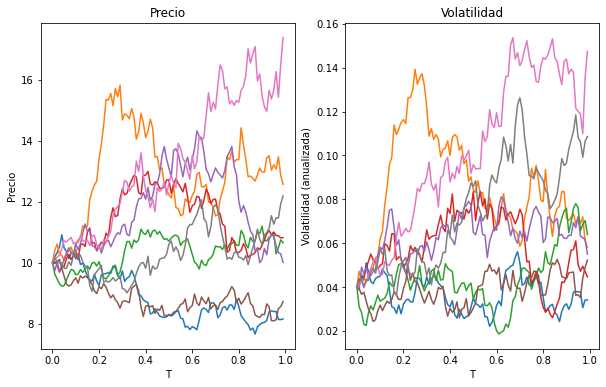

In [3]:
fig, (ax0,ax1)= plt.subplots(1,2,figsize=(10,6))

for n in range(8):
    dT = 0.01
    Tinc, Tfin= 0,1
    t_vec = np.arange(Tinc,Tfin,dT)
    ro = 0.7
    kappa = 1.5
    theta = 0.07
    r= 0.02
    sigma = 0.2

    S_vec = np.zeros(len(t_vec))
    V_vec = np.zeros(len(t_vec))

    S_vec[0] = 10
    V_vec[0] = 0.2*0.2

    cov = np.array([[1,ro],[ro,1]])

    Z = np.random.multivariate_normal([0,0], cov, (len(t_vec)))

    for i in range(1,len(t_vec)):  #Discretizaciones para los procesos de S y V
        V_vec[i] = np.maximum(V_vec[i-1]+ kappa*(theta-V_vec[i-1])*dT + sigma*np.sqrt(V_vec[i-1]*dT)*Z[i-1,0],0 )
        S_vec[i] = S_vec[i-1] * np.exp( (r-0.5*V_vec[i-1])*dT + np.sqrt(V_vec[i-1]*dT)*Z[i-1,1])  
    
    
    ax0.plot(t_vec,S_vec)
    ax1.plot(t_vec,V_vec)


ax0.set_title('Precio')
ax1.set_title('Volatilidad')
ax0.set_xlabel('T')
ax1.set_xlabel('T')
ax0.set_ylabel('Precio')
ax1.set_ylabel('Volatilidad (anualizada)')

plt.show()     

Prueba de Priceo con inversion de Fourier

In [3]:
%%time
v0 = 0.1 #Varianza inicial
theta = 0.15 # media de la volatilidad a largo plazo
kappa = 3 # tasa de reversion de la media
sigma = 0.2 #volatilidad de la volatilidad
rho = -0.9 #correlacion entre el subyacente y la volatilidad


dx=0.1 # Diferencial para integrar con la inversion de Fourier
S0 = 90
K = 100
alpha = 1 # Parametro regularizador de acuerdo con Carr Madan (1999)
T = 1
r=0.03
q=0
param = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}

print('Precio HEST ', alphaCF_Heston_price(dx,alpha,S0,K,T,r,q,param))


Precio HEST  10.034239834989432
Wall time: 9.97 ms


### Calibracion Datos Schoutens

Conjunto de datos sacados del paper de Schoutens et al (2003) "A Perfect Calibration. Now What?". Son un buen benchmark para probar el funcionamiento de la calibracion. Estos datos ya estan depurados de arbitrajes estaticos

In [4]:
#Cargamos los datos
datosSCH = np.loadtxt('datosSchoutens.txt')

TTM = np.array([0.0361,0.2,1.1944,2.1916,4.2056,5.1639]) # Son 6 Maturities
Strikes = datosSCH[:,0]
iv = np.array([])
stk = np.array([])
tau = []
for i in range(1,7):
    t = []
    t.append(TTM[i-1])
    x = datosSCH[:,0]
    y = datosSCH[:,i]
    iv_ = y[y>0]
    stk_ = x[y>0]
    iv = np.concatenate((iv,iv_), axis=None)
    stk = np.concatenate((stk,stk_), axis=None)
    t = t*(len(iv_))
    tau = tau + t

La calibracion se hace con Average relative percentual error (ARPE), buscando minimizar para $N$ datos y el conjunto de parametros $\chi$ la funcion $arpe = \frac{1}{N} \Sigma \frac{|\sigma_{MKT} - \sigma(K,T,\chi)|}{\sigma_{MKT}}$

In [4]:
#Inicializo los vectores de la calibracion
S0 = 2461.44
r = 0.03 
K = stk[1:]
T = np.array(tau)[1:]
P = iv[1:]

tic = time.time()

# Constraints
#cons = {'type': 'ineq', 'fun': lambda x: 2*x[1]*x[2] - x[3]**2 }

#Parametros iniciales
x0 = [-0.8,0.3,0.5,1,0.1] #rho,theta,sigma,kappa,v0 
#x0 =[-0.9,0.1,0.1,0.1,0.1] #Este dio buen arpe con SLSQP

#Limites para la minimizacion, no corresponde para todos los metodos. En este caso solo para SLSQP
bnds= [[-1,1],[1e-2,1],[1e-3,1],[1e-3,5],[1e-3,0.1]]

dx=0.1
alpha=0.8

#Algoritmo para minimizar
metodo = 'SLSQP' # SLSQP BFGS Nelder-Mead

def arpe(x): #Funcion ARPE
    rho,theta,sigma,kappa,v0 = [param for param in x]
    
    parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}
    
    err = 0
    for i in range(len(P)):
      err += (np.abs(P[i]-implied_volatility( alphaCF_Heston_price(dx,alpha,S0,K[i],T[i],r,0,parametros), S0, K[i], T[i], r,0, tipo="C", method="fsolve", disp=True ))/P[i])/len(P)
    
    return err 

result = minimize(arpe, x0, tol = 1e-3, method=metodo, options={'maxiter': 1e4 }, bounds=bnds) #, constraints=cons)
rho,theta,sigma,kappa,v0 = [param for param in result.x]
y = result.fun

tiempo = time.time()- tic

print('Arpe ', y)
print(rho,theta,sigma,kappa,v0) 
print(tiempo)

Arpe  0.009106679809373255
-0.6478236100597801 0.07403451122701425 0.3703234681919737 0.5866439341192637 0.06687720654264806
134.47259974479675


Para registrar resultados

In [ ]:
fsalida=open('SchoutensHEST.txt','a')
fsalida.write(str(metodo)+',')
fsalida.write('%10.9f' %(rho)+',')
fsalida.write('%10.9f' % (theta)+',')
fsalida.write('%10.9f' %(sigma)+',')
fsalida.write('%10.9f' % (kappa)+',')
fsalida.write('%10.9f' % (v0)+',')
fsalida.write('%10.8f' % (y)+',')
fsalida.write('%10.5f' % (tiempo)+'\n')
fsalida.close()


Para ver los resultados por $T$

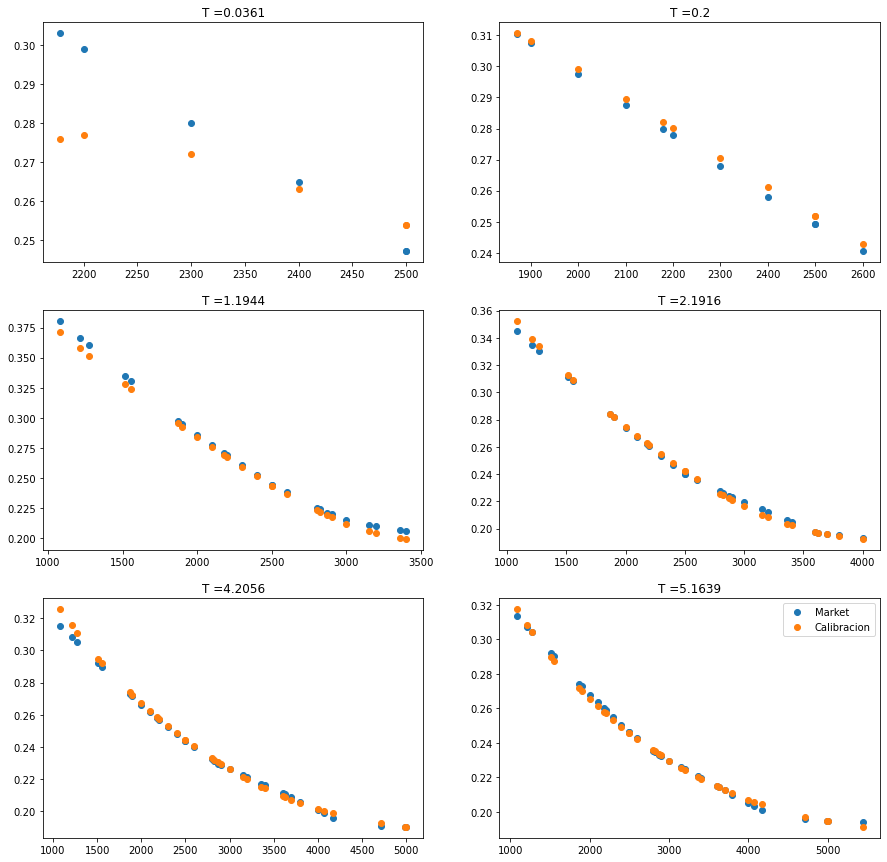

In [5]:
parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}

fig, ax = plt.subplots(3,2,figsize=(15, 15))

t = TTM[0] 
stkT = stk[tau == t][1:]
ivT = iv[tau == t][1:]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,0].set_title('T ={}'.format(t))
ax[0,0].scatter(stkT,ivT, label='Market')
ax[0,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[1] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,1].set_title('T ={}'.format(t))
ax[0,1].scatter(stkT,ivT, label='Market')
ax[0,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[2] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,0].set_title('T ={}'.format(t))
ax[1,0].scatter(stkT,ivT, label='Market')
ax[1,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[3] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,1].set_title('T ={}'.format(t))
ax[1,1].scatter(stkT,ivT, label='Market')
ax[1,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[4] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,0].set_title('T ={}'.format(t))
ax[2,0].scatter(stkT,ivT, label='Market')
ax[2,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[5] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,1].set_title('T ={}'.format(t))
ax[2,1].scatter(stkT,ivT, label='Market')
ax[2,1].scatter(stkT,np.array(prHest), label='Calibracion')
ax[2,1].legend()

### Calibracion Datos SPX de YFninance

In [5]:
#Cargo data de un Csv y me quedo con ciertas columnas
dataSPX = pd.read_csv('datoscallsSPX.csv')
dataSPX.reset_index(inplace=True)
dataSPX = dataSPX[['strike', 'bid', 'ask', 'volume', 'Spot',
       'Moneyness', 'TTM', 'mid', 'vi_bs']]

In [6]:
dataSPX.describe()

,strike,bid,ask,volume,Spot,Moneyness,TTM,mid,vi_bs
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,4222.189873,224.281646,227.028228,113.245570,4072.429932,0.975302,168.901266,225.654937,0.200199
std,447.210703,226.088337,228.638062,260.933385,0.000000,0.103131,149.460291,227.361821,0.027824
min,3000.000000,0.000000,0.100000,11.000000,4072.429932,0.747235,34.000000,0.050000,0.145296
25%,3945.000000,29.550000,30.200000,20.000000,4072.429932,0.903981,34.000000,29.875000,0.173975
50%,4150.000000,159.900000,161.000000,41.000000,4072.429932,0.981308,113.000000,160.450000,0.196728
75%,4505.000000,351.600000,356.950000,123.000000,4072.429932,1.032303,204.000000,354.325000,0.219622
max,5450.000000,1180.000000,1194.400000,2888.000000,4072.429932,1.357477,505.000000,1187.200000,0.279168


Veamos los datos preliminarmente

<Figure size 432x288 with 0 Axes>

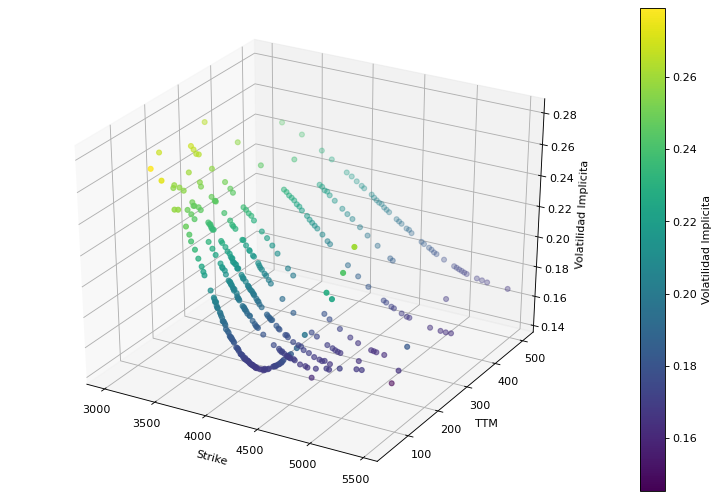

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig = plt.figure(figsize = (12, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter3D(dataSPX['strike'],dataSPX['TTM'], dataSPX['vi_bs'],c=dataSPX['vi_bs'])

cbar=plt.colorbar(pnt3d)
cbar.set_label("Volatilidad Implicita")
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.set_xlabel('Strike')
ax.set_ylabel('TTM')
ax.set_zlabel('Volatilidad Implicita')
plt.show()

Para Aplicar la calibracion hay que depurar los datos de arbitrajes estaticos. Esto resulta necesario para que la calibracion sea adecuada bajo criterios de no arbitraje. Las condiciones a checkear son 4. 
1. Butterfly spread
2. Calendar spread
3. Vertical spread
4. Cotas para el valor del derivado

In [8]:
S0 = 4072.42
arb1= check_butterfly_spread(dataSPX)[0] #La funcion devuelve una lista de los indices que no 
arb2= check_calendar_spread(dataSPX)[0]  #cumplen las condiciones pedidas.
arb3= check_vertical_spread(dataSPX)[0]
arb4= price_bounds(dataSPX,S0)
indices = set(arb1+arb2+arb3+arb4)

In [9]:
dataSPX.drop(list(indices),inplace=True)

In [10]:
dataSPX.describe()

,strike,bid,ask,volume,Spot,Moneyness,TTM,mid,vi_bs
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000
mean,4231.986900,231.272707,234.180349,108.606987,4072.429932,0.974774,175.611354,232.726528,0.200785
std,483.505207,237.747510,240.549531,200.637871,0.000000,0.111080,153.091167,239.146917,0.028865
min,3000.000000,0.000000,0.100000,11.000000,4072.429932,0.747235,34.000000,0.050000,0.145296
25%,3940.000000,29.000000,29.700000,20.000000,4072.429932,0.897011,85.000000,29.350000,0.173064
50%,4150.000000,168.300000,169.700000,46.000000,4072.429932,0.981308,113.000000,169.000000,0.199334
75%,4540.000000,365.200000,370.900000,142.000000,4072.429932,1.033612,204.000000,368.050000,0.220596
max,5450.000000,1180.000000,1194.400000,2204.000000,4072.429932,1.357477,505.000000,1187.200000,0.273386


<Figure size 432x288 with 0 Axes>

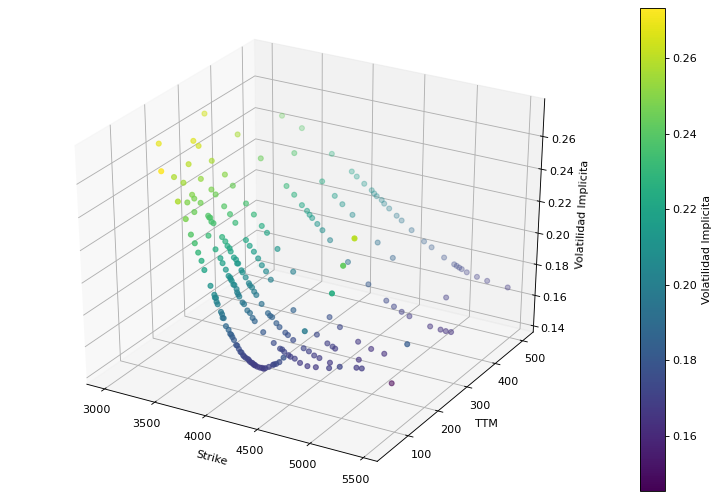

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig = plt.figure(figsize = (12, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter3D(dataSPX['strike'],dataSPX['TTM'], dataSPX['vi_bs'],c=dataSPX['vi_bs'])

cbar=plt.colorbar(pnt3d)
cbar.set_label("Volatilidad Implicita")
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.set_xlabel('Strike')
ax.set_ylabel('TTM')
ax.set_zlabel('Volatilidad Implicita')
plt.show()

In [12]:
#Correr estos datos ya depurados si no se quiere correr lo de arriba
dataSPX = pd.read_csv('datoscallsSPX_noArb.csv')

Ahora si calibramos 

In [13]:
S0 = 4072.4299
r = 0.03 
K = dataSPX.strike.to_numpy()
T = dataSPX.TTM.to_numpy()/365
P = dataSPX.vi_bs.to_numpy()

#Constraints
#cons = {'type': 'ineq', 'fun': lambda x: 2*x[1]*x[2] - x[3]**2 }

#Condiciones iniciales
x0 = [-0.8,0.3,0.5,1,0.1] #rho,theta,sigma,kappa,v0
#x0 =[-0.9,0.1,0.1,0.1,0.1] #alternativo

#Limites para la minimizacion, no corresponde para todos los metodos. En este caso solo para SLSQP
bnds= [[-1,1],[1e-2,1],[1e-3,1],[1e-3,5],[1e-3,1]]


dx=0.1
alpha=0.8

#Algoritmo de minimizacion
metodo = 'SLSQP' # SLSQP BFGS Nelder-Mead

def arpe(x):
    rho,theta,sigma,kappa,v0 = [param for param in x]
    
    parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}

    err = 0
    for i in range(len(P)):

      err += (np.abs(P[i]-implied_volatility(alphaCF_Heston_price(dx,alpha,S0,K[i],T[i],r,0,parametros),S0,K[i],T[i],r,0,tipo="C",method="fsolve",disp=True))/P[i])/len(P)

          
    return err 

tic = time.time()
result = minimize(arpe, x0, tol = 1e-3, method=metodo, options={'maxiter': 1e4 }, bounds=bnds)#, constraints=cons) 
tiempo = time.time() - tic
y = result.fun
rho,theta,sigma,kappa,v0 = [param for param in result.x]

In [14]:
print(rho,theta,sigma,kappa,v0)
print('Arpe ', y)
print('Tiempo ', tiempo)

-0.6474715664504785 0.08260275591411112 0.5104301507662053 0.683716679051628 0.04198030959190851
Arpe  0.024131451551686323
Tiempo  194.85093188285828


In [24]:
fsalida=open('SPX_HEST.txt','a')
fsalida.write(str(metodo)+',')
fsalida.write('%10.9f' %(rho)+',')
fsalida.write('%10.9f' % (theta)+',')
fsalida.write('%10.9f' %(sigma)+',')
fsalida.write('%10.9f' % (kappa)+',')
fsalida.write('%10.9f' % (v0)+',')
fsalida.write('%10.8f' % (y)+',')
fsalida.write('%10.5f' % (tiempo)+'\n')
fsalida.close()

In [15]:
TTMs = [34,85,113,155,204,323,414,505]
TTMs = np.array(TTMs)/365

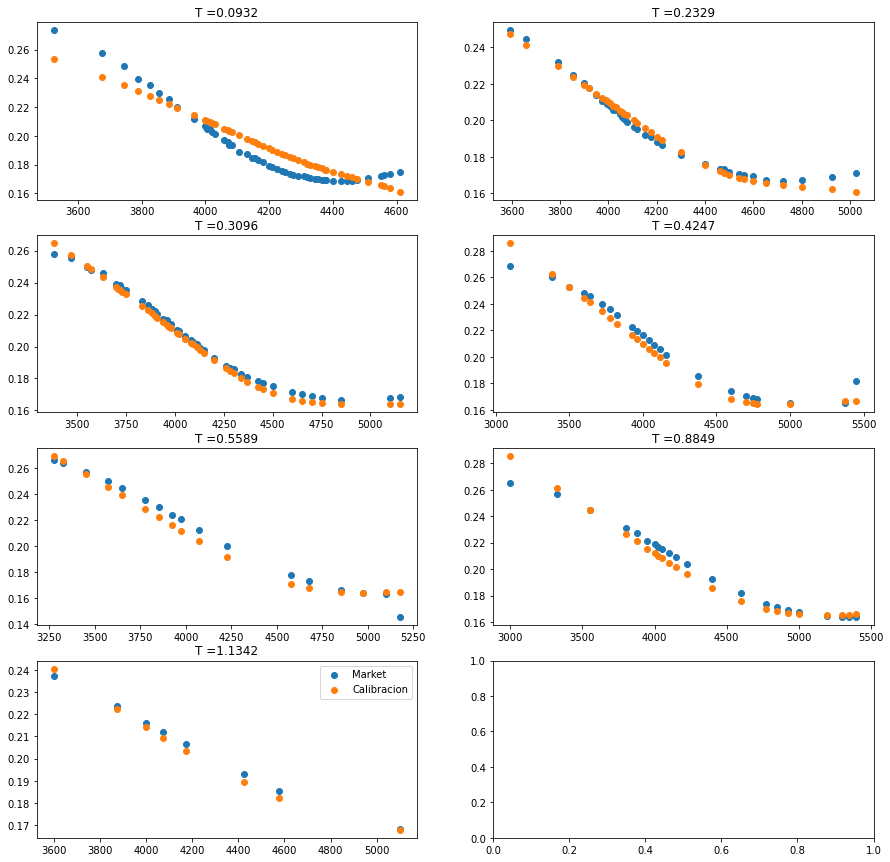

In [18]:
#rho,theta,sigma,kappa,v0 = [-0.6474715664504785, 0.08260275591411112, 0.5104301507662053, 0.683716679051628, 0.04198030959190851] 

parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}

fig, ax = plt.subplots(4,2,figsize=(15, 15))

t = TTMs[0] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,0].set_title('T ={}'.format(round(t,4)))
ax[0,0].scatter(stkT,ivT, label='Market')
ax[0,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[1] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,1].set_title('T ={}'.format(round(t,4)))
ax[0,1].scatter(stkT,ivT, label='Market')
ax[0,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[2] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,0].set_title('T ={}'.format(round(t,4)))
ax[1,0].scatter(stkT,ivT, label='Market')
ax[1,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[3] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,1].set_title('T ={}'.format(round(t,4)))
ax[1,1].scatter(stkT,ivT, label='Market')
ax[1,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[4] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,0].set_title('T ={}'.format(round(t,4)))
ax[2,0].scatter(stkT,ivT, label='Market')
ax[2,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[5] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,1].set_title('T ={}'.format(round(t,4)))
ax[2,1].scatter(stkT,ivT, label='Market')
ax[2,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[6] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[3,0].set_title('T ={}'.format(round(t,4)))
ax[3,0].scatter(stkT,ivT, label='Market')
ax[3,0].scatter(stkT,np.array(prHest), label='Calibracion')
ax[3,0].legend()

Ahora la superficie de Volatilidad

In [21]:
#Inicializa la grilla arbitraria
K = np.arange(3000,5500,200)
T = np.arange(0.4,3,0.1)

K0, T0 = np.meshgrid(K, T,indexing='ij')
parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}
vsheston = np.zeros((len(K),len(T)))

#Calcula los valores de volatilidad para cada punto de la grilla
for i in range(len(K)):
    for j in range(len(T)):
        vsheston[i,j]= implied_volatility(alphaCF_Heston_price(dx,alpha,S0,K[i],T[j],r,0,parametros), S0, K[i], T[j], r,0, tipo="C", method="fsolve", disp=True)

Text(0.5, 0, 'TTM')

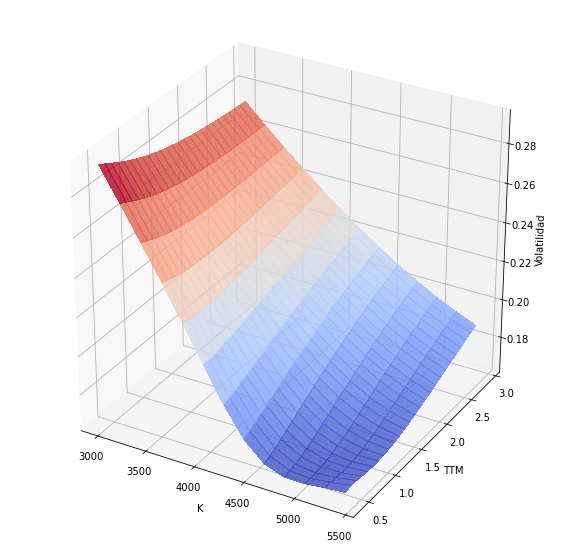

In [22]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(K0, T0, vsheston, cmap=cm.coolwarm, linewidth=0, antialiased=False,alpha=0.8)
plt.cm.jet.set_bad(alpha=0.0)
ax.set_zlabel('Volatilidad')
ax.set_xlabel('K')
ax.set_ylabel('TTM')

#### Prueba con RMSE weighted spread

Probamos otra funcion objetivo que es $wRMSE = \sqrt{\Sigma w_{i}(\sigma_{MKT} - \sigma(K,T,\chi))^2}$ con $w_{i} = \frac{1}{|bid_{i} - ask_{i}|}$

In [13]:
S0 = 4072.4299
r = 0.03 
K = dataSPX.strike.to_numpy()
T = dataSPX.TTM.to_numpy()/365
P = dataSPX.vi_bs.to_numpy()

bid = dataSPX.bid.to_numpy()
ask = dataSPX.ask.to_numpy()

weights = 1/np.abs(bid - ask)
# weights = 1/(len(P))     # Descomentar para hacer RMSE normal



cons = {'type': 'ineq', 'fun': lambda x: 2*x[1]*x[2] - x[3]**2 }

x0 = [-0.8,0.3,0.5,1,0.1]
bnds= [[-1,1],[1e-2,2],[1e-3,2],[1e-3,5],[1e-3,2]]

dx=0.1
alpha=0.8

metodo = 'SLSQP' # SLSQP BFGS Nelder-Mead

def wRMSE(x): #Esta es la funcion que cambia respecto de las celdas anteriores
    rho,theta,sigma,kappa,v0 = [param for param in x]
    
    parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}

    err = 0
    for i in range(len(P)):

      err += weights[i]*((P[i]-implied_volatility(alphaCF_Heston_price(dx,alpha,S0,K[i],T[i],r,0,parametros),S0,K[i],T[i],r,0,tipo="C",method="fsolve",disp=True))**2)

    return err 

tic = time.time()
result = minimize(wRMSE, x0, tol = 1e-3, method= metodo, options={'maxiter': 1e4 }, bounds=bnds)#, constraints=cons)
tiempo = time.time() - tic
y = result.fun
rho,theta,sigma,kappa,v0 = [param for param in result.x]

In [14]:
print(rho,theta,sigma,kappa,v0)
print('wRMSE ', np.sqrt(y))
print('Tiempo ', tiempo)

-0.6363265931149378 0.31627869588366003 0.5297802670304321 0.11802999485891832 0.04096387777178871
wRMSE  0.10710579033436594
Tiempo  222.37680339813232


Calculo Arpe para los parametros de wRMSE

In [15]:
x_ = [rho,theta,sigma,kappa,v0]

def arpe(x):
    rho,theta,sigma,kappa,v0 = [param for param in x]
    parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}
    err = 0
    for i in range(len(P)):
      err += (np.abs(P[i]-implied_volatility(alphaCF_Heston_price(dx,alpha,S0,K[i],T[i],r,0,parametros),S0,K[i],T[i],r,0,tipo="C",method="fsolve",disp=True))/P[i])/len(P)
          
    return err

z = arpe(x_)
print('Arpe ', z) 

Arpe  0.027255919692498486


In [54]:
fsalida=open('SPX_wRMSE_HEST.txt','a')
fsalida.write(str(metodo)+',')
fsalida.write('%10.9f' %(rho)+',')
fsalida.write('%10.9f' % (theta)+',')
fsalida.write('%10.9f' %(sigma)+',')
fsalida.write('%10.9f' % (kappa)+',')
fsalida.write('%10.9f' % (v0)+',')
fsalida.write('%10.8f' % (y)+',')
fsalida.write('%10.7f' % (z)+',')
fsalida.write('%10.5f' % (tiempo)+'\n')
fsalida.close()

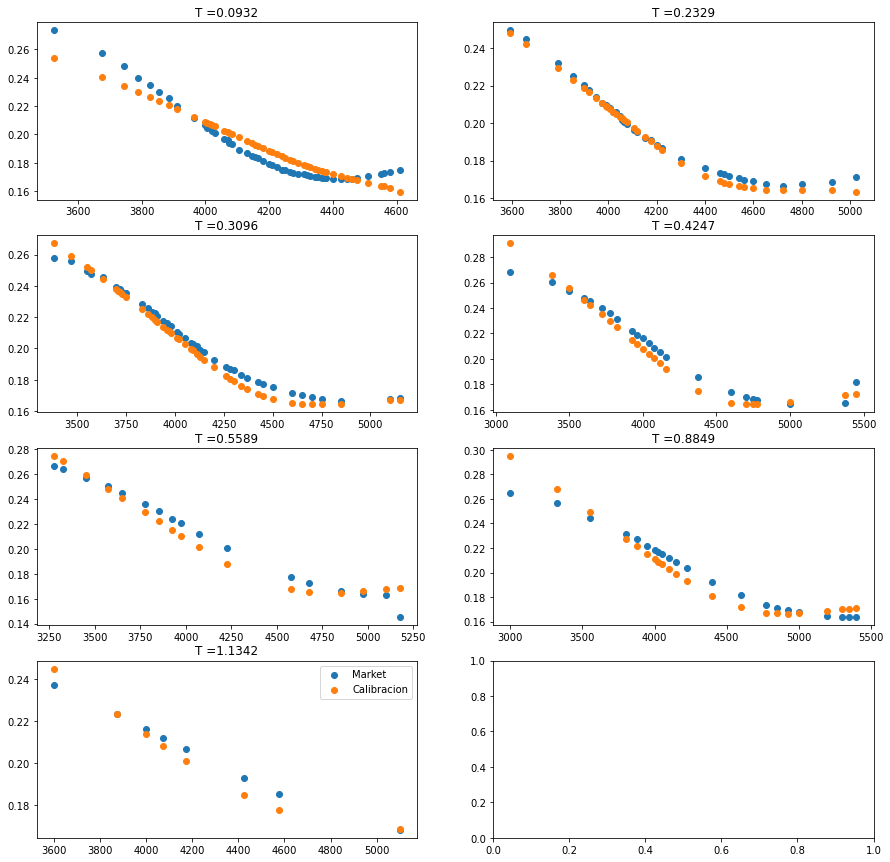

In [16]:

parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0}

fig, ax = plt.subplots(4,2,figsize=(15, 15))

t = TTMs[0] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,0].set_title('T ={}'.format(round(t,4)))
ax[0,0].scatter(stkT,ivT, label='Market')
ax[0,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[1] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,1].set_title('T ={}'.format(round(t,4)))
ax[0,1].scatter(stkT,ivT, label='Market')
ax[0,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[2] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,0].set_title('T ={}'.format(round(t,4)))
ax[1,0].scatter(stkT,ivT, label='Market')
ax[1,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[3] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,1].set_title('T ={}'.format(round(t,4)))
ax[1,1].scatter(stkT,ivT, label='Market')
ax[1,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[4] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,0].set_title('T ={}'.format(round(t,4)))
ax[2,0].scatter(stkT,ivT, label='Market')
ax[2,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[5] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,1].set_title('T ={}'.format(round(t,4)))
ax[2,1].scatter(stkT,ivT, label='Market')
ax[2,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[6] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_Heston_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[3,0].set_title('T ={}'.format(round(t,4)))
ax[3,0].scatter(stkT,ivT, label='Market')
ax[3,0].scatter(stkT,np.array(prHest), label='Calibracion')
ax[3,0].legend()

## Heston With Jumps

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, fsolve
from scipy.integrate import simps

In [27]:
from pricers import *
from impvol import *
from opcion_europea_bs import opcion_europea_bs

### Simulacion

El proceso de Heston WJ se puede ver simulado en lo siguente

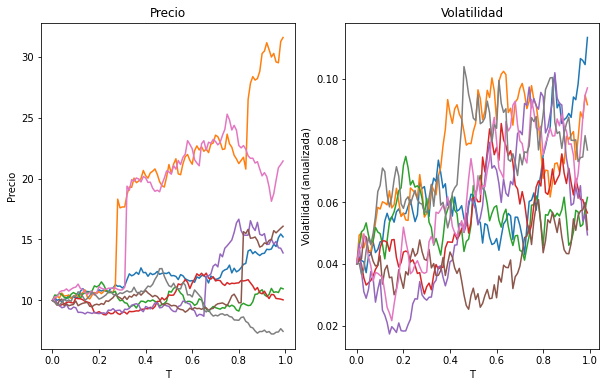

In [46]:
fig, (ax0,ax1)= plt.subplots(1,2,figsize=(10,6))
for n in range(8):
    dT = 0.01
    Tinc, Tfin= 0,1
    t_vec = np.arange(Tinc,Tfin,dT)
    ro = 0.7
    kappa = 1.5
    theta = 0.07
    r= 0.02
    sigma = 0.2
    landa = 1
    muJ=0.3
    sigmaJ=0.2
    S_vec = np.zeros(len(t_vec))
    V_vec = np.zeros(len(t_vec))

    S_vec[0] = 10
    V_vec[0] = 0.2*0.2

    cov = np.array([[1,ro],[ro,1]])

    Z = np.random.multivariate_normal([0,0], cov, (len(t_vec)))
    N = np.random.poisson(lam=landa*dT, size=len(t_vec))  #Para el proceso de Merton

    for i in range(1,len(t_vec)): #Discretizaciones para S y V, con un proceso de Merton sumado a S
        logY = np.random.normal(loc=muJ,scale=sigmaJ, size=(N[i]))

        if N[i] ==0:
            M = 0
        if N[i] != 0:
            M = np.cumsum(logY)


        V_vec[i] = np.maximum(V_vec[i-1]+ kappa*(theta-V_vec[i-1])*dT + sigma*np.sqrt(V_vec[i-1]*dT)*Z[i-1,0],0 )
        S_vec[i] = S_vec[i-1] * np.exp( (r-0.5*V_vec[i-1])*dT + np.sqrt(V_vec[i-1]*dT)*Z[i-1,1] + M) 
    
    ax0.plot(t_vec,S_vec)
    ax1.plot(t_vec,V_vec)

ax0.set_title('Precio')
ax1.set_title('Volatilidad')
ax0.set_xlabel('T')
ax1.set_xlabel('T')
ax0.set_ylabel('Precio')
ax1.set_ylabel('Volatilidad (anualizada)')

plt.show()     

Prueba de Priceo con inversion de Fourier

In [26]:
%%time
v0 = 0.1
theta = 0.15
kappa = 3
sigma = 0.2
rho = -0.9
landa = 0.5 #Intensidad de los Saltos
muJ = 0.2 # media del proceso de Merton
sigmaJ = 0.3 # Varianza del proceso 

dx=0.1
S0 = 90
K = 100
alpha = 1
T = 1
r=0.03
q=0

param = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0, 
        'landa':landa, 'muJ':muJ, 'sigmaJ':sigmaJ}

print('Precio HESWJ ', alphaCF_HestonWJ_price(dx,alpha,S0,K,T,r,q,param))

Precio HESWJ  13.386330957119949
Wall time: 218 ms


### Calibracion Datos Schoutens

Conjunto de datos sacados del paper de Schoutens et al (2003) "A Perfect Calibration. Now What?". Son un buen benchmark para probar el funcionamiento de la calibracion.

In [28]:
datosSCH = np.loadtxt('datosSchoutens.txt')

TTM = np.array([0.0361,0.2,1.1944,2.1916,4.2056,5.1639]) 
Strikes = datosSCH[:,0]
iv = np.array([])
stk = np.array([])
tau = []
for i in range(1,7):
    t = []
    t.append(TTM[i-1])
    x = datosSCH[:,0]
    y = datosSCH[:,i]
    iv_ = y[y>0]
    stk_ = x[y>0]
    iv = np.concatenate((iv,iv_), axis=None)
    stk = np.concatenate((stk,stk_), axis=None)
    t = t*(len(iv_))
    tau = tau + t

La calibracion se hace con Average relative percentual error (ARPE), buscando minimizar para $N$ datos y el conjunto de parametros $\chi$ la funcion $arpe = \frac{1}{N} \Sigma \frac{|\sigma_{MKT} - \sigma(K,T,\chi)|}{\sigma_{MKT}}$

In [29]:
S0 = 2461.44
r = 0.03 # Esto puede hacerse mas realista luego
K = stk
T = np.array(tau)
P = iv

tic = time.time()
#cons = {'type': 'ineq', 'fun': lambda x: 2*x[1]*x[2] - x[3]**2 }

x0 = [-0.9, 0.1, 0.1, 0.1, 0.1, 1, 0.1, 0.1] # rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ
bnds= [[-1,1],[1e-2,4],[1e-3,2],[1e-3,1],[1e-3,1],[1e-3,5],[1e-3,1],[1e-3,1]]

dx=0.1
alpha=0.8

metodo = 'Nelder-Mead' # SLSQP BFGS Nelder-Mead

def arpe(x):
    rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ = [param for param in x]
    
    parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0, 
        'landa':landa, 'muJ':muJ, 'sigmaJ':sigmaJ}

    err = 0
    for i in range(len(P)):
      err += (np.abs(P[i]-implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,K[i],T[i],r,0,parametros), S0, K[i], T[i], r,0, tipo="C", method="fsolve", disp=True ))/P[i])/len(P)
    
          
    return err 

result = minimize(arpe, x0, tol = 1e-3, method= metodo, options={'maxiter': 1e4 })#, bounds=bnds)#, constraints=cons) # Esto segun corresponda el metodo
rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ = [param for param in result.x]
y = result.fun

tiempo = time.time()- tic

In [30]:
print('Arpe ', y)
print(rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ) 
print(tiempo)

Arpe  0.027594240529681867
-0.7577544539716208 0.13473995036167852 0.13648148551019665 0.028958589777874022 0.0527273657607429 0.11132219278444391 0.17747381494523473 0.16983444252307028
3477.7748548984528


In [31]:
fsalida=open('SchoutensHESTWJ.txt','a')
fsalida.write(str(metodo)+',')
fsalida.write('%10.9f' %(rho)+',')
fsalida.write('%10.9f' % (theta)+',')
fsalida.write('%10.9f' %(sigma)+',')
fsalida.write('%10.9f' % (kappa)+',')
fsalida.write('%10.9f' % (v0)+',')
fsalida.write('%10.9f' % (landa)+',')
fsalida.write('%10.9f' % (muJ)+',')
fsalida.write('%10.9f' % (sigmaJ)+',')
fsalida.write('%10.8f' % (y)+',')
fsalida.write('%10.5f' % (tiempo)+'\n')
fsalida.close()

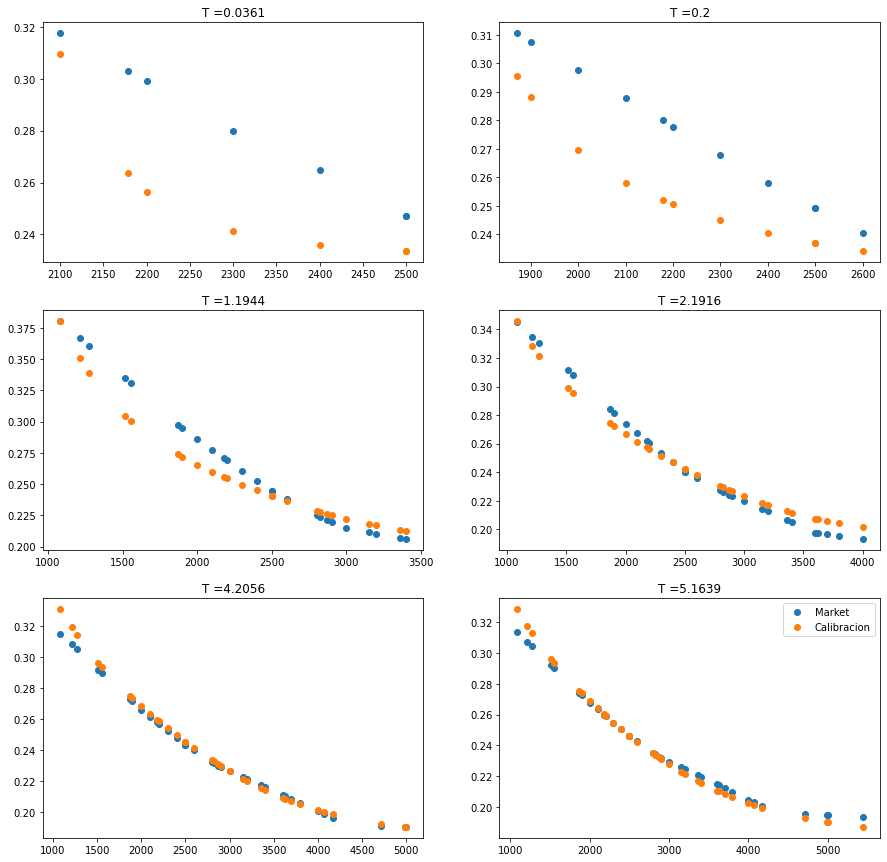

In [32]:
parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0, 
        'landa':landa, 'muJ':muJ, 'sigmaJ':sigmaJ}

fig, ax = plt.subplots(3,2,figsize=(15, 15))

t = TTM[0] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,0].set_title('T ={}'.format(t))
ax[0,0].scatter(stkT,ivT, label='Market')
ax[0,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[1] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,1].set_title('T ={}'.format(t))
ax[0,1].scatter(stkT,ivT, label='Market')
ax[0,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[2] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,0].set_title('T ={}'.format(t))
ax[1,0].scatter(stkT,ivT, label='Market')
ax[1,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[3] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,1].set_title('T ={}'.format(t))
ax[1,1].scatter(stkT,ivT, label='Market')
ax[1,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[4] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,0].set_title('T ={}'.format(t))
ax[2,0].scatter(stkT,ivT, label='Market')
ax[2,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTM[5] 
stkT = stk[tau == t]
ivT = iv[tau == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,1].set_title('T ={}'.format(t))
ax[2,1].scatter(stkT,ivT, label='Market')
ax[2,1].scatter(stkT,np.array(prHest), label='Calibracion')
ax[2,1].legend()

### Calibracion Datos SPX de YFninance

In [23]:
dataSPX = pd.read_csv('datoscallsSPX_noArb.csv')


In [25]:
S0 = 4072.4299
r = 0.03 # Esto puede hacerse mas realista luego
K = dataSPX.strike.to_numpy()
T = dataSPX.TTM.to_numpy()/365
P = dataSPX.vi_bs.to_numpy()

#cons = {'type': 'ineq', 'fun': lambda x: 2*x[1]*x[2] - x[3]**2 }

x0 = [-0.7, 0.1, 0.1, 0.1, 0.1, 1, 0.1, 0.1] # rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ
bnds= [[-1,1],[1e-2,4],[1e-3,2],[1e-3,1],[1e-3,1],[1e-3,5],[1e-3,1],[1e-3,1]]


dx=0.1
alpha=0.8

metodo = 'SLSQP' # SLSQP BFGS Nelder-Mead

def arpe(x):
    rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ = [param for param in x]
    
    parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0, 
        'landa':landa, 'muJ':muJ, 'sigmaJ':sigmaJ}

    err = 0
    for i in range(len(P)):

      err += (np.abs(P[i]-implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,K[i],T[i],r,0,parametros),S0,K[i],T[i],r,0,tipo="C",method="fsolve",disp=True))/P[i])/len(P)

          
    return err 

tic = time.time()
result = minimize(arpe, x0, tol = 1e-3, method=metodo, options={'maxiter': 1e4 }, bounds=bnds)#, constraints=cons)
tiempo = time.time() - tic


In [26]:
y = result.fun
rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ = [param for param in result.x]
print('Arpe ', y)
print(rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ) 
print(tiempo)

Arpe  0.06588266716632861
-0.7491186433721116 0.061456882723109306 0.4630584482746794 0.08046261179064898 0.04435104883795616 1.2110987010563645 0.055405740756483315 0.039812417425703274
196.40850806236267


In [ ]:
fsalida=open('SPX_HESTWJ.txt','a')
fsalida.write(str(metodo)+',')
fsalida.write('%10.9f' %(rho)+',')
fsalida.write('%10.9f' % (theta)+',')
fsalida.write('%10.9f' %(sigma)+',')
fsalida.write('%10.9f' % (kappa)+',')
fsalida.write('%10.9f' % (v0)+',')
fsalida.write('%10.9f' % (landa)+',')
fsalida.write('%10.9f' % (muJ)+',')
fsalida.write('%10.9f' % (sigmaJ)+',')
fsalida.write('%10.8f' % (y)+',')
fsalida.write('%10.5f' % (tiempo)+'\n')
fsalida.close()

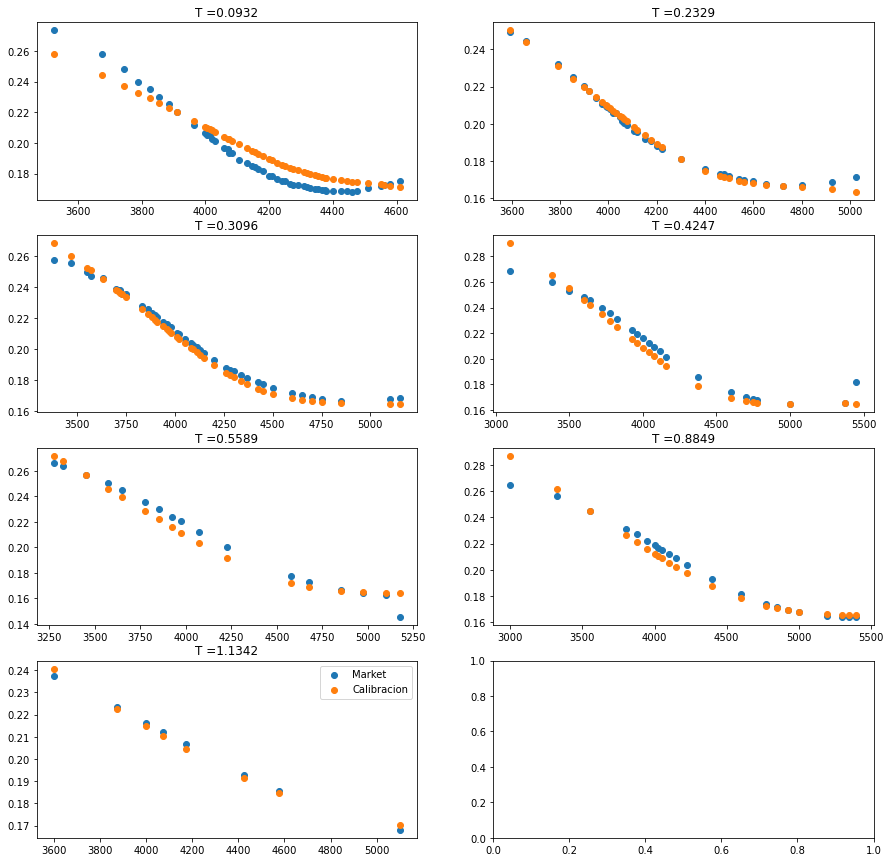

In [35]:
#rho,theta,sigma,kappa,v0,landa,muJ,sigmaJ = [-0.696308472, 0.071444310, 0.574065347, 1.005953496, 0.039533011, 1.005743473, 0.051767347, 0.003707517]
parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0, 
        'landa':landa, 'muJ':muJ, 'sigmaJ':sigmaJ}

fig, ax = plt.subplots(4,2,figsize=(15, 15))

t = TTMs[0] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,0].set_title('T ={}'.format(round(t,4)))
ax[0,0].scatter(stkT,ivT, label='Market')
ax[0,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[1] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[0,1].set_title('T ={}'.format(round(t,4)))
ax[0,1].scatter(stkT,ivT, label='Market')
ax[0,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[2] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,0].set_title('T ={}'.format(round(t,4)))
ax[1,0].scatter(stkT,ivT, label='Market')
ax[1,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[3] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[1,1].set_title('T ={}'.format(round(t,4)))
ax[1,1].scatter(stkT,ivT, label='Market')
ax[1,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[4] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,0].set_title('T ={}'.format(round(t,4)))
ax[2,0].scatter(stkT,ivT, label='Market')
ax[2,0].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[5] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[2,1].set_title('T ={}'.format(round(t,4)))
ax[2,1].scatter(stkT,ivT, label='Market')
ax[2,1].scatter(stkT,np.array(prHest), label='Calibracion')

t = TTMs[6] 
stkT = K[T == t]
ivT = P[T == t]
prHest = [implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,stkT[i],t,r,0,parametros), S0, stkT[i], t, r,0, tipo="C", method="fsolve", disp=True) for i in range(len(stkT))]
ax[3,0].set_title('T ={}'.format(round(t,4)))
ax[3,0].scatter(stkT,ivT, label='Market')
ax[3,0].scatter(stkT,np.array(prHest), label='Calibracion')
ax[3,0].legend()

Ahora la superficie de volatilidad

In [29]:
K = np.arange(3000,5500,200)
T = np.arange(0.36,3,0.1)

K0, T0 = np.meshgrid(K, T,indexing='ij')
parametros = {'rho':rho,'theta':theta,'sigma':sigma,'kappa':kappa,'v0':v0, 
        'landa':landa, 'muJ':muJ, 'sigmaJ':sigmaJ}
vsheston = np.zeros((len(K),len(T)))

for i in range(len(K)):
    for j in range(len(T)):
        vsheston[i,j]= implied_volatility(alphaCF_HestonWJ_price(dx,alpha,S0,K[i],T[j],r,0,parametros), S0, K[i], T[j], r,0, tipo="C", method="fsolve", disp=True)

Text(0.5, 0, 'TTM')

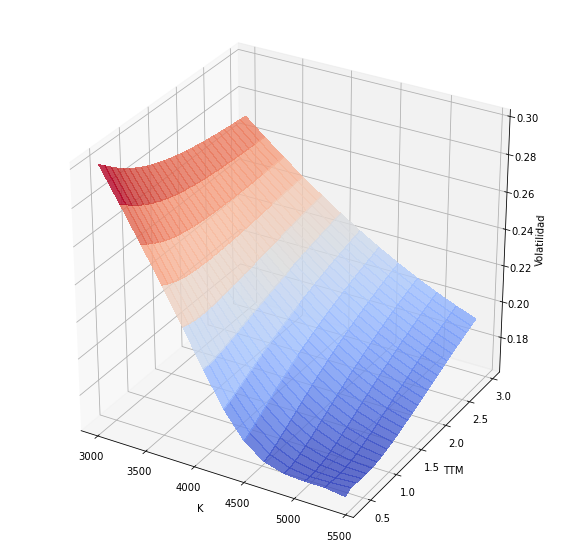

In [30]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(K0, T0, vsheston, cmap=cm.coolwarm, linewidth=0, antialiased=False,alpha=0.8)
plt.cm.jet.set_bad(alpha=0.0)
ax.set_zlabel('Volatilidad')
ax.set_xlabel('K')
ax.set_ylabel('TTM')

## SVI

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from svi import * #Importa funciones para SVI
from impvol import *
from opcion_europea_bs import opcion_europea_bs

### Preliminares

Forma parametrica para la varianza total $w(k,t_1) = \sigma_{BS}^2 t_1 = a+b\{\rho(k-m)+\sqrt{(k-m)^2+\sigma^2}\}$, donde $t_1$ es un tiempo fijo y $k = log(\frac{K}{F_{t_1}})$, con $F_{t_1}$ el precio forward a tiempo $t_1$ del spot del subyacente

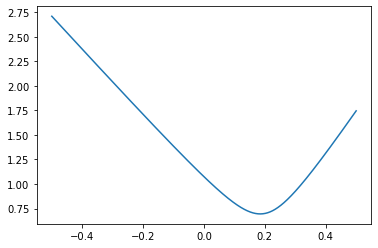

In [41]:
# Forma del Set = [a,b,rho,m,sigma]
setT1 = np.array([0.3,4,0.15,.2,.1])
k = np.linspace(-0.5,0.5,1000)
plt.plot(k,rawSVI(k,*setT1)) 


Queremos que se ajuste a los datos penalizando cruces entre las curvas de varianza total, pues esta es monotona creciente. Se computa la "crossedness" para ello y se la penalizara en el ajuste

In [4]:
setT1 = np.array([1,0.2,-0.4,.2,.1])
setT2 = np.array([1,0.1,-.3,.25,0.2])

raices, c = calendar_arbitrage(setT1,setT2) #Busca las raices que se cruzan en curvas 
print('Raices ', raices)                    #de varianza total, computa la crossednes
print('Crossedness ', c)

Raices  [0.16132169 0.281838  ]
Crossedness  0.14844044204767215


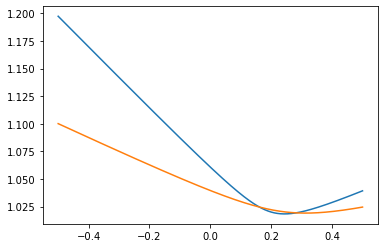

In [5]:
k = np.linspace(-0.5,0.5,1000)
plt.plot(k,rawSVI(k,*setT1))
plt.plot(k,rawSVI(k,*setT2))

La metodologia general es ver que no se crucen las curvas. Para ello el ajuste toma una adivinanza de los parametros iniciales a partir de la varianza ATM y luego se enmiendan los valores con una funcion objetivo que penalize la crossedness de las lineas y el butterfly spread

### Calibracion Schoutens

Primero para los datos de Schoutens

In [42]:
datosSCH = np.loadtxt('datosSchoutens.txt')

TTM = np.array([0.0361,0.2,1.1944,2.1916,4.2056,5.1639]) 
Strikes = datosSCH[:,0]
iv = np.array([])
stk = np.array([])
tau = []
for i in range(1,7):
    t = []
    t.append(TTM[i-1])
    x = datosSCH[:,0]
    y = datosSCH[:,i]
    iv_ = y[y>0]
    stk_ = x[y>0]
    iv = np.concatenate((iv,iv_), axis=None)
    stk = np.concatenate((stk,stk_), axis=None)
    t = t*(len(iv_))
    tau = tau + t

In [43]:
#Limpio los datos para la forma de las funciones
dataSCH= pd.DataFrame([stk,iv,tau])
dataSCH = dataSCH.transpose()
dataSCH.columns = ['Strike','vi_bs','TTM']

In [44]:
S0 = 2461.44
r = 0.03
dataSCH['Spot'] =  S0
dataSCH['F'] =  2461.44*np.exp(r*dataSCH['TTM'].to_numpy())
dataSCH['mid'] = [opcion_europea_bs('C',S0,dataSCH.Strike.to_numpy()[i],dataSCH.TTM.to_numpy()[i],r,dataSCH.vi_bs.to_numpy()[i],0) for i in range(len(dataSCH.Strike.to_numpy()))]


In [45]:
#El modelo esta en funcion del log stike definido asi
dataSCH['k'] = np.log(dataSCH.Strike.to_numpy()/dataSCH.F.to_numpy())

In [46]:
#Adivinanza inicial con un modelo de parametros reducidos y de dinamica ATM determinada de antemano
guess = sviSqrtFit(dataSCH)

In [47]:
#Calibracion en si, toma el problema de minimizacion y computa penalidades por arbitrajes
r=0.03
result = sviFitQR(dataSCH,guess,pF=10000,method='Nelder-Mead')

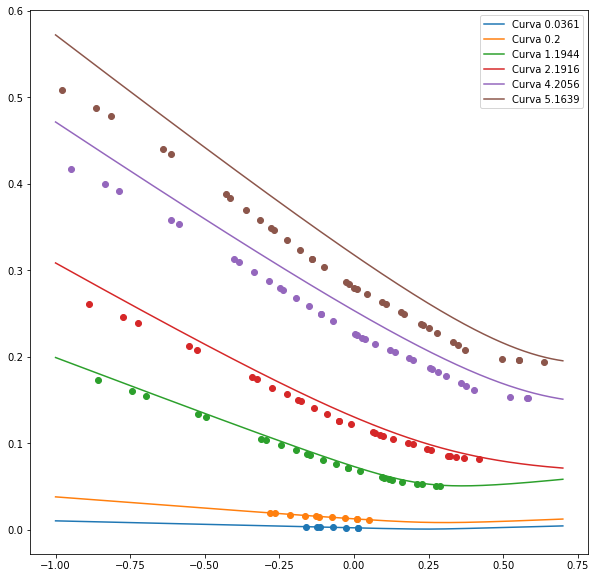

In [48]:
k = np.linspace(-1,0.7,500)

test = result  #Ver que graficar
#test = guess

plt.figure(figsize=(10,10))
for i in range(len(test)):
    a,b,rho,m,sigma  = test[i]
    raw = rawSVI(k,a,b,rho,m,sigma)
    t=TTM[i]
    tau = dataSCH.TTM.to_numpy()
    logK = dataSCH.k.to_numpy()[tau==t]
    iv = dataSCH.vi_bs.to_numpy()[tau==t]
    plt.plot(k,raw, label='Curva {}'.format(str(TTM[i]))) #Curvas de varianza total
    plt.scatter(logK, t*(iv)**2) #Datos expresados segun varianza total

plt.legend()
plt.show()

### Calibracion SPX de YFinance

Ahora con los datos de mercado sacado con YFinance

In [49]:
dataSPX = pd.read_csv('datoscallsSPX.csv')

In [50]:
#Nos quedamos con lo importante
dataSPX = dataSPX[['strike','Spot','TTM','mid','vi_bs']]
dataSPX.columns = ['Strike','Spot','TTM','mid','vi_bs']

In [51]:
r = 0.03
dataSPX['TTM'] = dataSPX['TTM'].to_numpy()/365
dataSPX['F'] =  dataSPX['Spot'].to_numpy()*np.exp(r*(dataSPX['TTM'].to_numpy()))
dataSPX['k'] = np.log(dataSPX.Strike.to_numpy()/dataSPX.F.to_numpy())

In [52]:
guess = sviSqrtFit(dataSPX)

In [53]:
result = sviFitQR(dataSPX,guess,pF=1000)

c:\Users\julia\Documents\Universidad\FCEN\Analisis Cuantitativo en finanzas\IVS\volatility_modelling\Para Presentar\svi.py:298: RuntimeWarning: invalid value encountered in sqrt
  sviIV = np.sqrt(sviVar)
c:\Users\julia\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


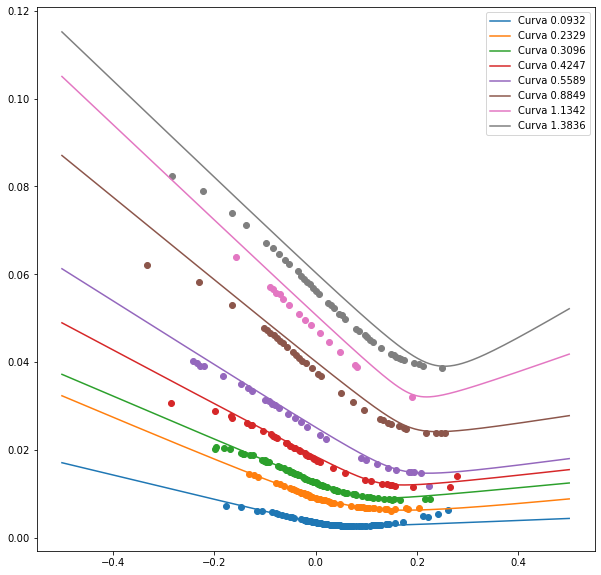

In [54]:
k = np.linspace(-0.5,0.5,500)

test = result
#test = guess

TTM = np.sort(dataSPX.TTM.unique())
plt.figure(figsize=(10,10))
for i in range(len(test)):
    a,b,rho,m,sigma  = test[i]
    raw = rawSVI(k,a,b,rho,m,sigma)
    t=TTM[i]
    tau = dataSPX.TTM.to_numpy()
    logK = dataSPX.k.to_numpy()[tau==t]
    iv = dataSPX.vi_bs.to_numpy()[tau==t]
    plt.plot(k,raw, label='Curva {}'.format(str(round(TTM[i],4))))
    plt.scatter(logK, t*(iv)**2)

plt.legend()
plt.show()

### Interpolacion

Por el Lema 5.1 de Gatheral(2013), hay una interpolacion donde la superficie de volatilidad esta libre de arbitraje estatico. Dicha interpolacion se construye tal que para $C_{i} = C(F_{i},K_{i},t_{i})$ con i correspondiente a $t_{i}=t_1,t_2$, se tiene que para $t$ entre $(t_{1},t_{2})$ la relacion entre los precios es $\frac{C_{t}}{K_{t}} = \alpha_{t}\frac{C_{1}}{K_{1}} + (1-\alpha_{t})\frac{C_{2}}{K_{2}} $, con $\alpha_{t}= \frac{\sqrt{\theta_{t_2}} -\sqrt{\theta_{t}}}{\sqrt{\theta_{t_2}} -\sqrt{\theta_{t_1}}}$. $\theta_{t}$ corresponde a una interpolacion monotona de la varianza total ATM. Esta relacion vale particularmente para $K_1=K_2=K_{t}$, que son movimientos unicamente en el eje $TTM$ 

Aca se agragan dos puntos extra entre cada valor de $T$ de la calibracion. Pueden agregarse mas arbitrariamente

In [28]:
#Esta interpolacion es en las rectas a strike fijo
S0= 4072
K = np.arange(2500,6000, 200)
TTM = np.sort(dataSPX.TTM.unique())
TTM_int = []
r = 0.03

#defino los puntos intermedios (dos en este caso) a los TTM para interpolar
for i in range(len(TTM)-1): 
    a= TTM[i]
    b= TTM[i+1]
    c= a + (b-a)/3
    d = a + 2*(b-a)/3
    TTM_int.append(c)
    TTM_int.append(d)

#Tomo las curvas obtenidas de la calibracion, del precio como de la volatilidad implicita
IV_calibracion = []
P_calibracion=[]
for i in range(len(TTM)):
    t = TTM[i]
    a,b,rho,m,sigma = result[i]

    k = np.log(K/(S0*np.exp(r*t)))
    sviIV = np.sqrt(rawSVI(k,a,b,rho,m,sigma)/t)
    precios = [opcion_europea_bs('C',S0,K[j],t,r,sviIV[j],0) for j in range(len(K))]
    precios= np.array(precios)
    IV_calibracion.append(sviIV)
    P_calibracion.append(precios)

#Computo la varianza total ATM
tht = computeW0(dataSPX)

#Hago una interpolacion en el tiempo para sacar el alfa
theta = interp1d(TTM,tht)

def alfa(t1,t2,t):
    a= np.sqrt(theta(t2))
    b= np.sqrt(theta(t1))

    num = a - np.sqrt(theta(t))
    dem = a - b
    return num/dem


#Completo las rectas para los TTM intermedios por la regla de interpolacion
IV_interpolacion = []
P_interpolacion=[]
for i in range(len(TTM)-1):
    t1 = TTM[i]
    preciot1 = P_calibracion[i]
    t2 = TTM[i+1]
    preciot2 = P_calibracion[i+1]
    
    for j in [0,1]:
        z = i + j
        t0=TTM_int[z]
        a = alfa(t1,t2,t0)
        b = 1 - a
        precios_interp = [(a*preciot1[l] + b*preciot2[l]) for l in range(len(K))]
        IV_interp = [implied_volatility(precios_interp[n],S0,K[n],t0,r,0,tipo='C',method='fsolve', disp=True) for n in range(len(precios_interp))]
        IV_interpolacion.append(IV_interp)
        P_interpolacion.append(precios_interp)


La superficie de volatilidad sin interpolar es la siguiente

Text(0.5, 0, 'TTM')

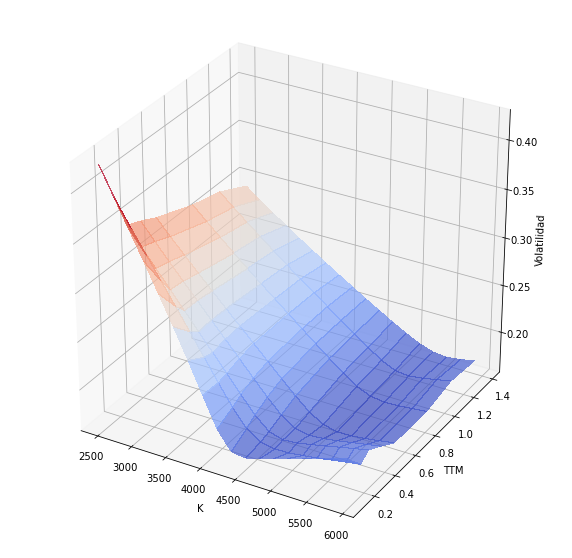

In [35]:
K = np.arange(2500,6000, 200)
T = list(TTM)#+ list(TTM_int)
T = np.sort(np.array(T))

K0, T0 = np.meshgrid(K, T,indexing='ij')

IVgridKT = np.zeros((len(K),len(T)))

j=0
k=0

for i in range(len(T)):
    IVgridKT[:,i]= IV_calibracion[i]

from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(K0, T0, IVgridKT, cmap=cm.coolwarm, linewidth=0, antialiased=False,alpha=0.7)
#ax.set_ylim(1.5,5)
plt.cm.jet.set_bad(alpha=0.0)
#ax.set_zlim(0,0.5)
ax.set_zlabel('Volatilidad')
ax.set_xlabel('K')
ax.set_ylabel('TTM')

Esto no resuelve la cuestion de la grilla arbitraria, para ello se usa la interpolacion. Veamos el plot para los precios

In [36]:
K = np.arange(2500,6000, 200)
T = list(TTM) + list(TTM_int) #Aca estan los nuevos puntos
T = np.sort(np.array(T))

K0, T0 = np.meshgrid(K, T,indexing='ij')

PgridKT = np.zeros((len(K),len(T)))

j=0
k=0

for i in range(len(T)): #Agrega en orden las curvas para graficar la grilla PgridKT
    if i%3 == 0:
        PgridKT[:,i]= P_calibracion[j]
        j+=1
    elif i%3 != 0:
        PgridKT[:,i]= P_interpolacion[k]
        k+=1


Text(0.5, 0, 'TTM')

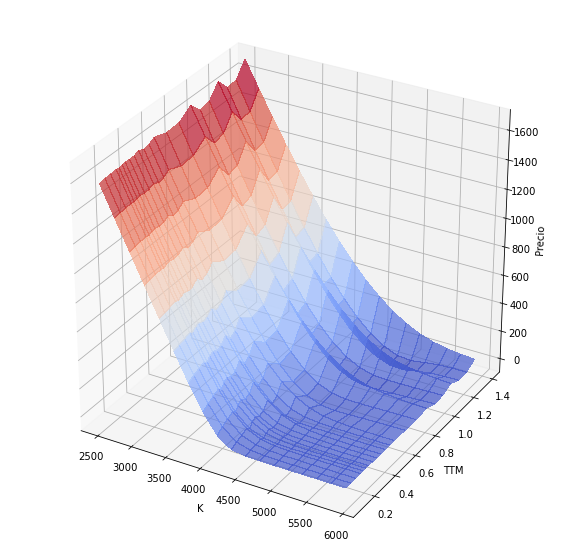

In [37]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(K0, T0, PgridKT, cmap=cm.coolwarm, linewidth=0, antialiased=False,alpha=0.7)
plt.cm.jet.set_bad(alpha=0.0)
ax.set_zlabel('Precio')
ax.set_xlabel('K')
ax.set_ylabel('TTM')

Ahora veamos la superficie de volatilidad

In [38]:
# Hay un problema numerico con la biseccion de la volatilidad. 
IV_interpolacion1 = IV_interpolacion.copy()
for i in range(len(IV_interpolacion1)):
    for j in range(len(IV_interpolacion1[i])):
        if IV_interpolacion1[i][j] == -1:
            IV_interpolacion1[i][j] = float(np.nan)

#Este codigo agarra los NAN y completa estos datos con el proximo valor cercano no nulo
import math
for i in range(len(IV_interpolacion1)):
  for j in range(1,len(IV_interpolacion1[i])):
    #forward
    if math.isnan(IV_interpolacion1[i][j]):
      IV_interpolacion1[i][j] = IV_interpolacion1[i][j-1]
  
  for j in range(1,len(IV_interpolacion1[i])):
    #backward
    k = len(IV_interpolacion1[i]) - j  
    if math.isnan(IV_interpolacion1[i][k-1]):
      IV_interpolacion1[i][k-1] = IV_interpolacion1[i][k]

In [39]:
K = np.arange(2500,6000, 200)
T = list(TTM) + list(TTM_int)
T = np.sort(np.array(T))

K0, T0 = np.meshgrid(K, T,indexing='ij')

IVgridKT = np.zeros((len(K),len(T)))

j=0
k=0

for i in range(len(T)):
    if i%3 == 0:
        IVgridKT[:,i]= IV_calibracion[j]
        j+=1
    elif i%3 != 0:
        IVgridKT[:,i]= IV_interpolacion1[k]
        k+=1



Text(0.5, 0, 'TTM')

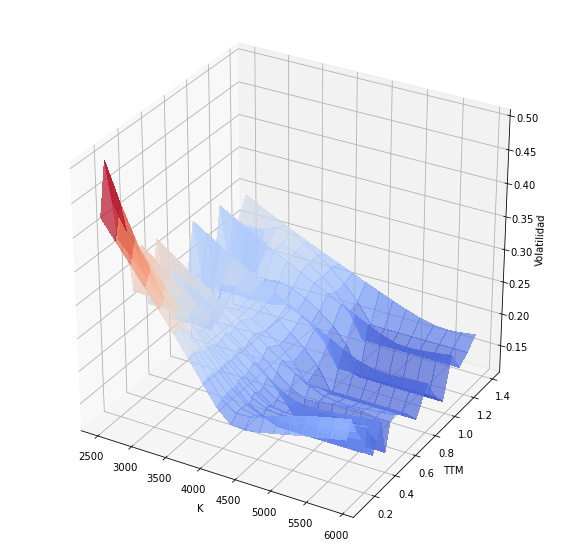

In [40]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(K0, T0, IVgridKT, cmap=cm.coolwarm, linewidth=0, antialiased=False,alpha=0.7)
#ax.set_ylim(1.5,5)
plt.cm.jet.set_bad(alpha=0.0)
ax.set_zlabel('Volatilidad')
ax.set_xlabel('K')
ax.set_ylabel('TTM')